In [46]:
from utils.steering_simple import SteeringModel
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from utils.find_similar_directions_in_sae import try_reconstruct, reconstruction_analysis, load_sae_decoder
from tqdm import tqdm

In [3]:
steering_vec = torch.load("directions/meandiffalllayers.pt")

In [9]:
decoder = load_sae_decoder(15, 0)

  Loading SAE weights from HuggingFace (andyrdt/saes-gpt-oss-20b)...


  SAE decoder shape: torch.Size([2880, 131072]) (d_model x n_features)


In [34]:
topkfeatures = find_top_k_features(steering_vec[15], decoder, 10000)

In [35]:
indices = [feature[0] for feature in topkfeatures]

In [36]:
weights = decoder[:,indices]

In [38]:
import torch

def sparse_topk_cossim(X, target, k):
    """
    X: (n_vectors, dim) tensor, e.g., (10000, 2880)
    target: (1, dim) or (dim,) tensor
    k: number of non-zero coefficients

    Returns: coefficients that maximize cos_sim with sparsity
    """
    # Ensure target is (dim,) shape
    if target.dim() > 1:
        target = target.squeeze(0)
    # Compute dot products between each row and target
    dot_products = X @ target    # (n_vectors,)
    # Get top-k indices
    topk_values, topk_indices = torch.topk(dot_products, k)
    # Create sparse coefficient vector
    coefficients = torch.zeros(X.shape[0], device=X.device)
    # Just use the dot products as initial coefficients (not yet optimal)
    coefficients[topk_indices] = topk_values
    # Optimize coefficients for the selected vectors
    X_selected = X[topk_indices]   # (k, dim)
    # Solve: c_selected = (X_selected @ X_selected.T)^-1 @ (X_selected @ target.T)
    # X_selected @ X_selected.T: (k, k), X_selected @ target: (k,)
    A = X_selected @ X_selected.T       # (k, k)
    b = (X_selected @ target).unsqueeze(-1)  # (k, 1)
    c_selected = torch.linalg.solve(A, b).squeeze()
    coefficients[topk_indices] = c_selected

    return coefficients, topk_indices

# Usage:
# Here, weights is shape (2880, 10000), so weights.T: (10000, 2880)
X = weights.T   # (10000, 2880)
coeffs, indices = sparse_topk_cossim(X, steering_vec[15], k=10)
result = coeffs @ X  # (2880,) your optimized linear combination

tensor([10.1164, 52.2103, -2.3956,  ...,  0.0000,  0.0000,  0.0000])

100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


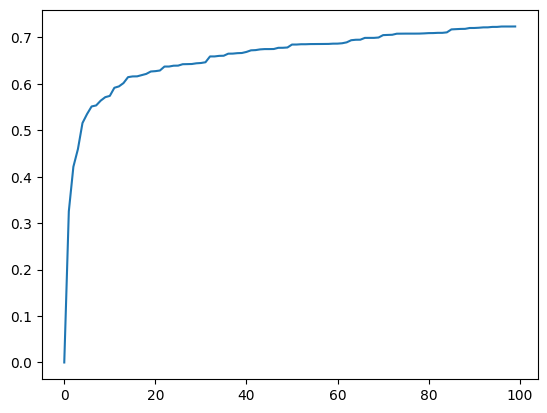

In [49]:
cossims = []
allcoeffs = []

for k in tqdm(range(100)):
    coeffs, indices = sparse_topk_cossim(X, steering_vec[15], k)
    result = coeffs @ X  # (2880,) your optimized linear combination
    allcoeffs += [coeffs]
    cossims += [F.cosine_similarity(result.unsqueeze(0), steering_vec[15].unsqueeze(0), dim=1)]
plt.plot(cossims)

In [61]:
weights.shape

torch.Size([2880, 10000])

In [71]:
allcoeffs[30][:30]

tensor([ 16.6591,  54.9018,   0.2122,  24.1071,  19.7887,  20.3269,   3.1289,
         37.5359,  14.2784,  -5.7524,  20.6222,  11.8261,  19.1237,  30.1379,
          3.2312,   2.1360,  13.3331,  16.3608,  21.3122,   2.4558,  12.3252,
         25.0378,   2.4181,  15.2103,   5.4539,  18.2319,  -2.3023,  -3.7377,
        -14.4824,   8.5057])

In [72]:
for index, n in enumerate(allcoeffs[30][:30]):
    print(topkfeatures[index], n)

(85955, 0.3255966007709503) tensor(16.6591)
(105444, 0.29984724521636963) tensor(54.9018)
(6122, 0.29494747519493103) tensor(0.2122)
(95195, 0.2902403771877289) tensor(24.1071)
(117873, 0.28550469875335693) tensor(19.7887)
(17587, 0.2822762131690979) tensor(20.3269)
(123849, 0.26742926239967346) tensor(3.1289)
(53866, 0.2662951946258545) tensor(37.5359)
(35140, 0.25900527834892273) tensor(14.2784)
(64970, 0.25687775015830994) tensor(-5.7524)
(453, 0.2561759948730469) tensor(20.6222)
(57968, 0.2519341707229614) tensor(11.8261)
(79639, 0.25003781914711) tensor(19.1237)
(87319, 0.24908293783664703) tensor(30.1379)
(98780, 0.24809354543685913) tensor(3.2312)
(100947, 0.2466259002685547) tensor(2.1360)
(9830, 0.24537484347820282) tensor(13.3331)
(6413, 0.24426572024822235) tensor(16.3608)
(49277, 0.2409435361623764) tensor(21.3122)
(4923, 0.24083466827869415) tensor(2.4558)
(8813, 0.24057424068450928) tensor(12.3252)
(114425, 0.24021542072296143) tensor(25.0378)
(40627, 0.2394578754901886) 

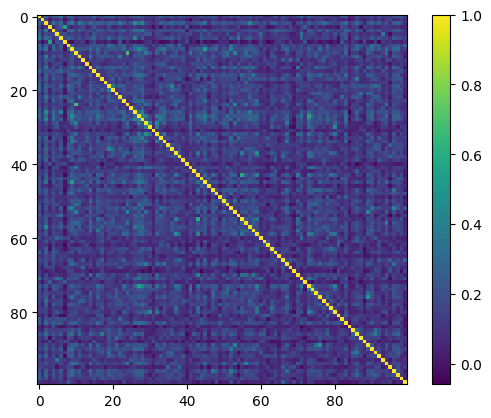

In [65]:
plt.imshow(cosine_similarity(weights.T[:100]))
plt.colorbar()
plt.show()

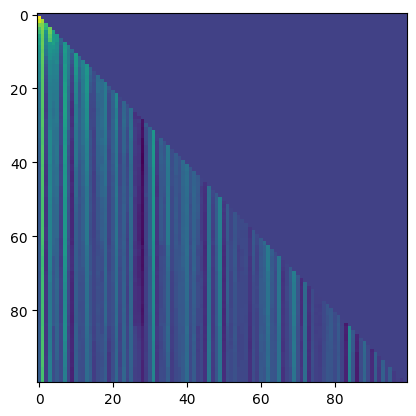

In [57]:
plt.imshow(torch.stack(allcoeffs)[:,:100])

In [42]:
F.cosine_similarity(result.unsqueeze(0), steering_vec[15].unsqueeze(0), dim=1)

tensor([0.5742])

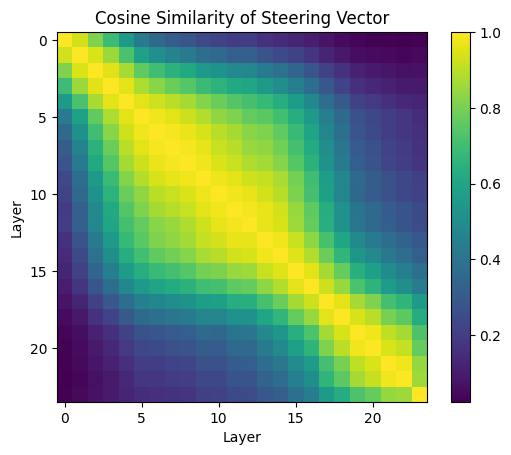

In [11]:
plt.imshow(cosine_similarity(steering_vec, steering_vec))
plt.colorbar()
plt.xlabel("Layer")
plt.ylabel("Layer")
plt.title("Cosine Similarity of Steering Vector")
plt.savefig("plots/cosine_similarity_of_steering_vector.png")
plt.show()

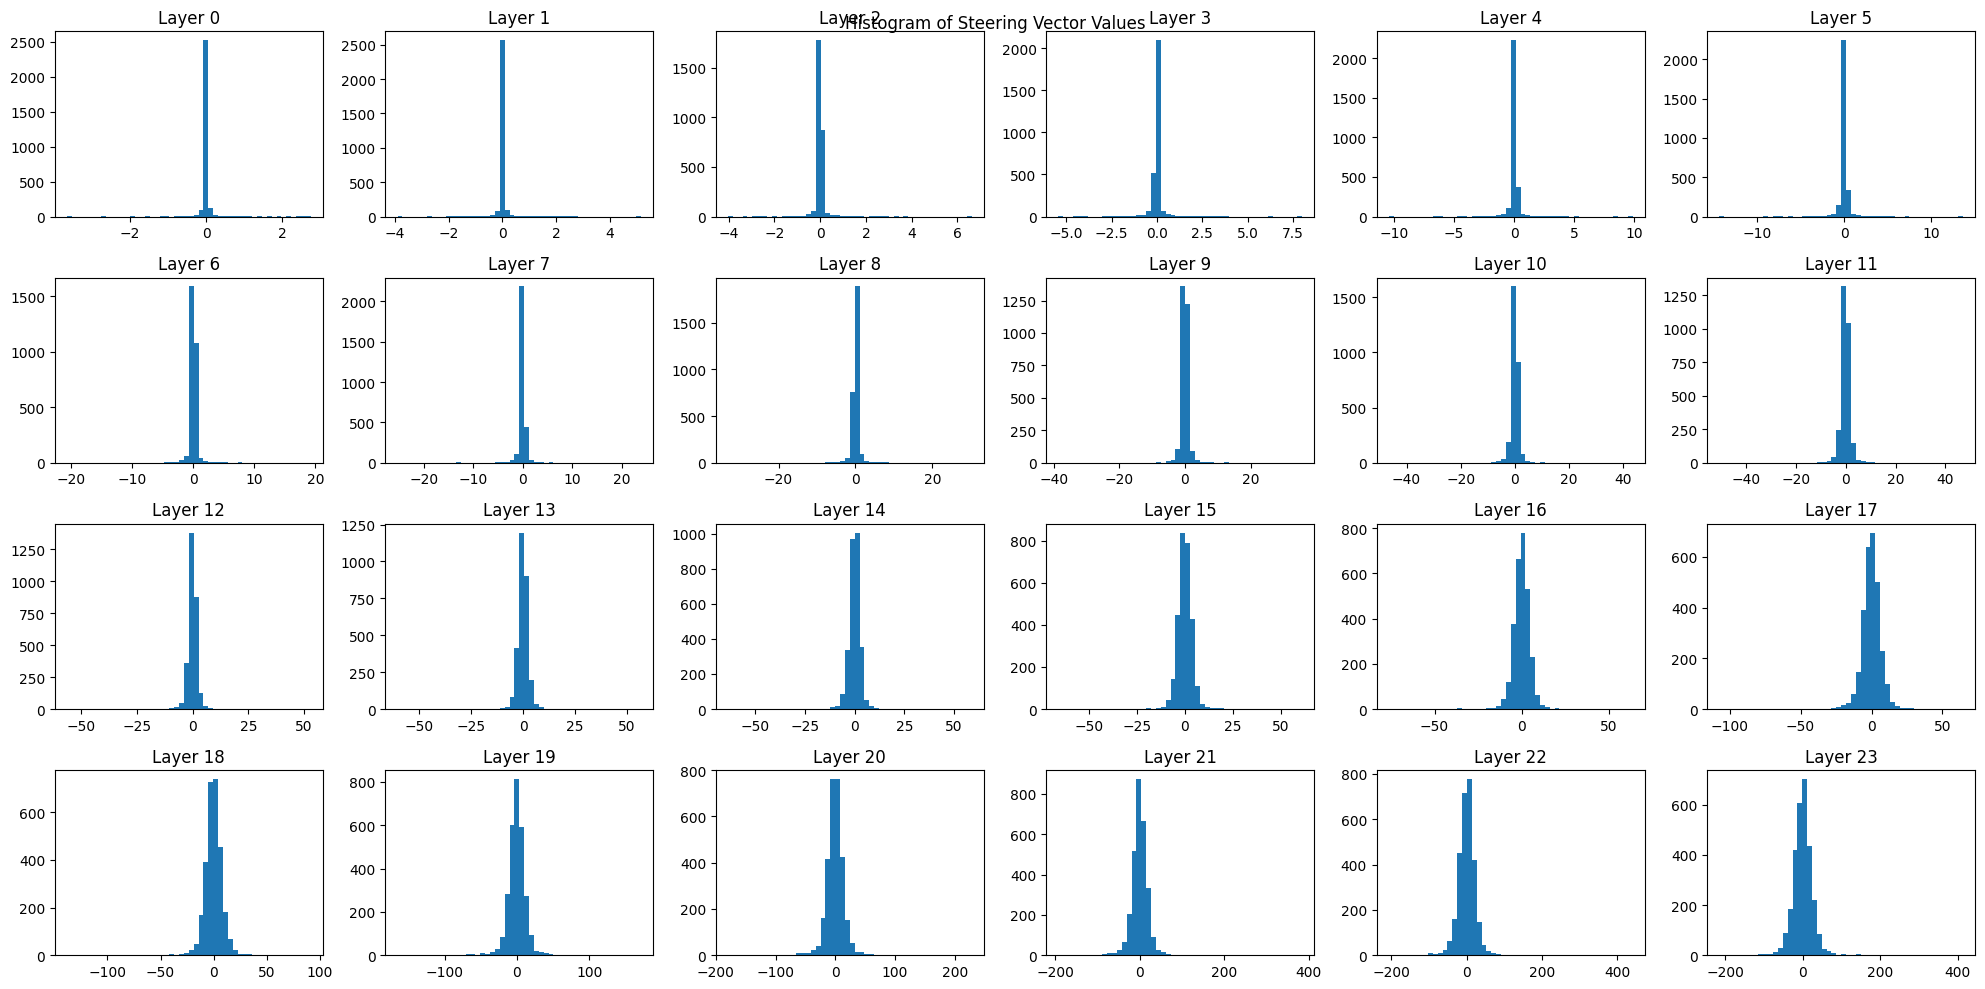

In [18]:
fig, ax = plt.subplots(4, 6, figsize=(20, 10))
for i in range(24):
    ax[i//6, i%6].hist(steering_vec[i], bins=50)
    ax[i//6, i%6].set_title(f"Layer {i}")
plt.tight_layout()
plt.suptitle("Histogram of Steering Vector Values")
plt.savefig("plots/histograms_of_steering_vector.png")
plt.show()

In [19]:
model = SteeringModel(
    "openai/gpt-oss-20b",
    steering_vectors={15: steering_vec[15]},  # or load from file
    alpha=1.0
)

Loading tokenizer...
Loading model...


Loading checkpoint shards: 100%|██████████| 3/3 [01:13<00:00, 24.37s/it]

Model loaded on cuda:0
Steering on 1 layers with alpha=1.0


In [79]:
prompt = model.tokenizer.apply_chat_template(
    [
        {"role": "user", "content": "What should I wear to the party tonight?"}
    ],
    tokenize=False,
    add_generation_prompt=True
)

In [69]:
model.set_alpha(-5)

In [80]:
for alpha in range(-8, 8, 1):
    print(alpha)
    print("\n")
    model.set_alpha(alpha)
    output = model.generate(prompt, max_tokens=256)
    print(output)
    print("\n\n")
    print("-"*100)
    print("\n\n")

-8


analysisWe have: i=1, j=2, k=1, l=2, m=1, n=2

For j, k, l: 2,1,2 -> 2,1,2 => 2-1-2 => 2-1-2 => (2-1)=2 => 2-1 => (2-1)=2 => 2-1-2 => (2-1-2) = 2-1-2 => (2-1-2)=2-1-2

We can? (i-1) = (2-1-2) => (2-1-2) => (2-1) = 2-2 = (2-1-2) => (2-1-2) + (2-1) = 2-2-2

-2-2-2

We might... let's-1-2 => (2-2-2) + (2-1) = (2-2-2) + (2-1) = (2-2-2) + (2-1) = (2-2-2) + (2-1) =>



----------------------------------------------------------------------------------------------------



-7


analysisWe have 2D: need to consider direction: θ; v; w; with w=1; v=2; θ=0

Use formula: v' = v*cosθ - w*sinθ; w' = w*cosθ + v*sinθ

Compute: v' = 2*cos0 - 1*sin0 = 2; w' = 1*cos0 + 2*sin0 = 1

So v' = 2; w' = 1

We want to: x = v' + w'; z = v' - w'; 
x=2+1=3; z=2-1=1

cosθ= (x + z)/2 = (3+1)/2 = 2; sinθ= (x - z)/2 = (3-1)/2 = 1

v = v' + w'; w= -v' + w'
= (2+1) =3; ( -2 +1)= -1
But for v: v' + w' =2+1=3; w= -v' + w' = -2+1= -1
v=3; w=1

So for



--------------------------------------------------------------------